# Data Pre-processing

In [ ]:
#Importing Libraries
import time
import numpy as np
from collections import Counter
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
#Load cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Split the training set to get validatation set because the
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42,  stratify=y_train) #stratify parameter ensures that the split respects the class distribution so training and validation sets will have balanced class distribution

print(f"Training set size  : {x_train.shape[0]}")
print(f"Validation set size: {x_val.shape[0]}")
print(f"Test set size      : {x_test.shape[0]}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Training set size  : 40000
Validation set size: 10000
Test set size      : 10000


In [ ]:
#Dataset Balance
train_classes = Counter(y_train.flatten())
val_classes = Counter(y_val.flatten())
test_classes = Counter(y_test.flatten())

print(f"Distribution of training set classes: {train_classes}")
print(f"Distribution of validation set classes: {val_classes}")
print(f"Distribution of test set classes: {test_classes}")

Distribution of training set classes: Counter({6: 4000, 7: 4000, 8: 4000, 3: 4000, 2: 4000, 1: 4000, 4: 4000, 9: 4000, 0: 4000, 5: 4000})
Distribution of validation set classes: Counter({2: 1000, 7: 1000, 1: 1000, 9: 1000, 6: 1000, 8: 1000, 0: 1000, 3: 1000, 5: 1000, 4: 1000})
Distribution of test set classes: Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


In [ ]:
#Normalization
#Pixel values in images range from 0 to 255. Normalization is applied to scale these values to the range between -1 and 1
x_train = (x_train/255.0)*2-1
x_test = (x_test/255.0)*2-1
x_val = (x_val/255.0)*2-1

#Sequential augmentation pipeline
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomCrop(32, 32),      #Crops the image to a size of 32x32
    tf.keras.layers.RandomFlip("horizontal"),#Flips the image horizontally
])

#Apply augmentation to the training set to ensure that the model sees different input variations
x_train = data_augmentation(x_train)

In [ ]:
#Training Hyperparameters
learning_rate = 0.001
batch_size = 32
num_of_epochs = 30
loss_function = 'sparse_categorical_crossentropy' #Used for multi-class classification with target label is integer.not one hot encoded

#Common model parameters
image_size = 32
num_of_classes = 10

#Callback Hyperparameters
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch:learning_rate*0.95**epoch)  #Dynamically reduce the learning rate
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #Training stops if validation loss does not improve for 10 epochs and ensures the best model with the lowest validation loss

In [ ]:
def plot_history(training_history, num_of_epochs=30):
    accuracy = training_history.history['accuracy']
    validation_accuracy = training_history.history['val_accuracy']
    loss = training_history.history['loss']
    validation_loss = training_history.history['val_loss']

    epoch_range = range(num_of_epochs)

    plt.figure(figsize=(9, 9))
    plt.subplot(1, 2, 1)
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.plot(epoch_range, accuracy, label='Training Acc')
    plt.plot(epoch_range, validation_accuracy, label='Validation Acc')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training & Validation Loss')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.plot(epoch_range, loss, label='Training Loss')
    plt.plot(epoch_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')

    plt.show()

# CNN

In [ ]:
def cnn(input_shape, num_of_classes):

    #Sequential model initialization
    model = models.Sequential()

    #First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)) #convolutional layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu')) #convolutional layer
    model.add(layers.MaxPooling2D((2, 2))) #MaxPooling
    model.add(layers.BatchNormalization()) #Normalization to stabilize and speed up training
    model.add(layers.Dropout(0.25)) #drops 25% of the neurons to prevent overfitting

    #Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu')) #convolutional layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu')) #convolutional layer
    model.add(layers.MaxPooling2D((2, 2))) #MaxPooling
    model.add(layers.BatchNormalization()) #Normalization to stabilize and speed up training
    model.add(layers.Dropout(0.25)) #Drops 25% of the neurons to prevent overfitting

    #Fully Connected Layers
    model.add(layers.Flatten()) #Convert 2D feature maps into a 1D vector
    model.add(layers.Dense(128, activation='relu')) #Fully connected layer with 128 neurons
    model.add(layers.BatchNormalization()) #Normalizes the dense layer output
    model.add(layers.Dropout(0.5)) #Drops 50% of the neurons to prevent overfitting
    model.add(layers.Dense(num_of_classes, activation='softmax')) #Dense layer with 10 neurons,  softmax activation to produce class probabilities

    return model


In [ ]:
#Compile the model
cnn_model = cnn(input_shape=(image_size, image_size, 3), num_of_classes=num_of_classes)
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_function,
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Model training
cnn_history = cnn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=num_of_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, learning_rate_scheduler]
)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3386 - loss: 2.0643 - val_accuracy: 0.5687 - val_loss: 1.1908 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5629 - loss: 1.2166 - val_accuracy: 0.6624 - val_loss: 0.9507 - learning_rate: 9.5000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6356 - loss: 1.0331 - val_accuracy: 0.6926 - val_loss: 0.8662 - learning_rate: 9.0250e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6773 - loss: 0.9239 - val_accuracy: 0.7165 - val_loss: 0.8037 - learning_rate: 8.5737e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6985 - loss: 0.8582 - val_accuracy: 0.7241 - val_loss: 0.7718 - learning_rate: 8.1451e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7219 - loss: 0.7980 - val_accuracy: 0.7351 - val_loss: 0.7542 - learning_rate: 7.7378e-04
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step 

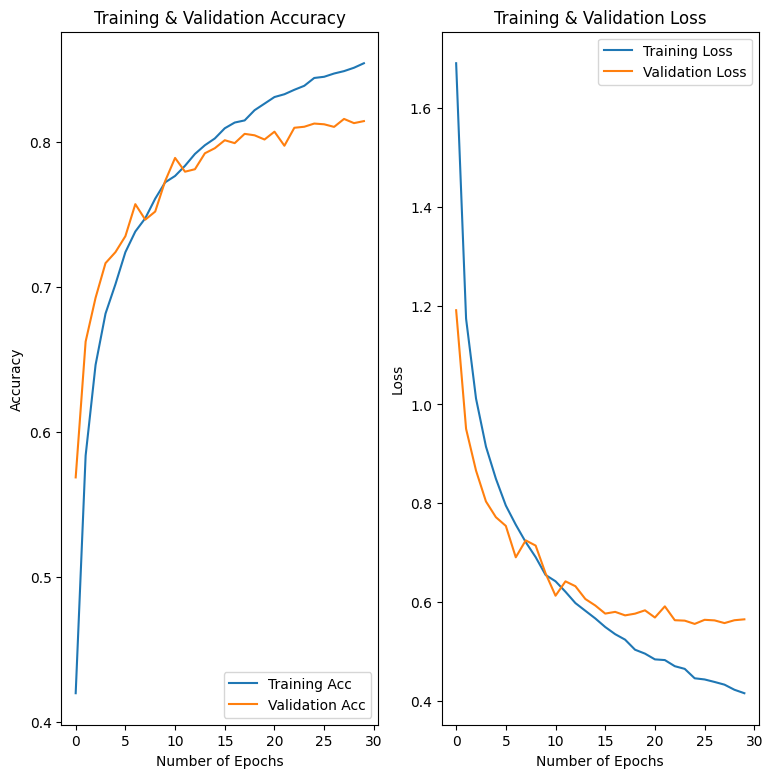

In [ ]:
plot_history(cnn_history)

# ResNet

In [ ]:
# Loading ResNet model without pre-trained weights
base_resnet = tf.keras.applications.ResNet50(
    include_top=False, #Remove the default classification head
    weights=None,  #No pre-trained weights
    input_shape=(image_size, image_size, 3) #Shape of the input images
)

#Custom classification head
x = Flatten()(base_resnet.output) #Reshapes the high-dimensional feature maps into a 1D vector
x = Dense(128, activation='relu')(x) #Dense layer with 128 neurons
output = Dense(num_of_classes, activation='softmax')(x) #Fully connected layer with 10 neurons for 10 classes

#Final model
resnet_model = Model(inputs=base_resnet.input,outputs=output)

In [ ]:
#Compile the model
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_function,
    metrics=['accuracy']
)

In [ ]:
#Model training
resnet_history = resnet_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=num_of_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, learning_rate_scheduler]
)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 99s 39ms/step - accuracy: 0.2826 - loss: 1.9916 - val_accuracy: 0.4159 - val_loss: 1.6681 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.4251 - loss: 1.5703 - val_accuracy: 0.4923 - val_loss: 1.4001 - learning_rate: 9.5000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.4864 - loss: 1.4253 - val_accuracy: 0.5405 - val_loss: 1.2386 - learning_rate: 9.0250e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.5597 - loss: 1.2262 - val_accuracy: 0.5429 - val_loss: 1.2951 - learning_rate: 8.5737e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.5967 - loss: 1.1417 - val_accuracy: 0.6181 - val_loss: 1.1041 - learning_rate: 8.1451e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.6484 - loss: 1.0005 - val_accuracy: 0.5535 - val_loss: 1.4745 - learning_rate: 7.7378e-04
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37

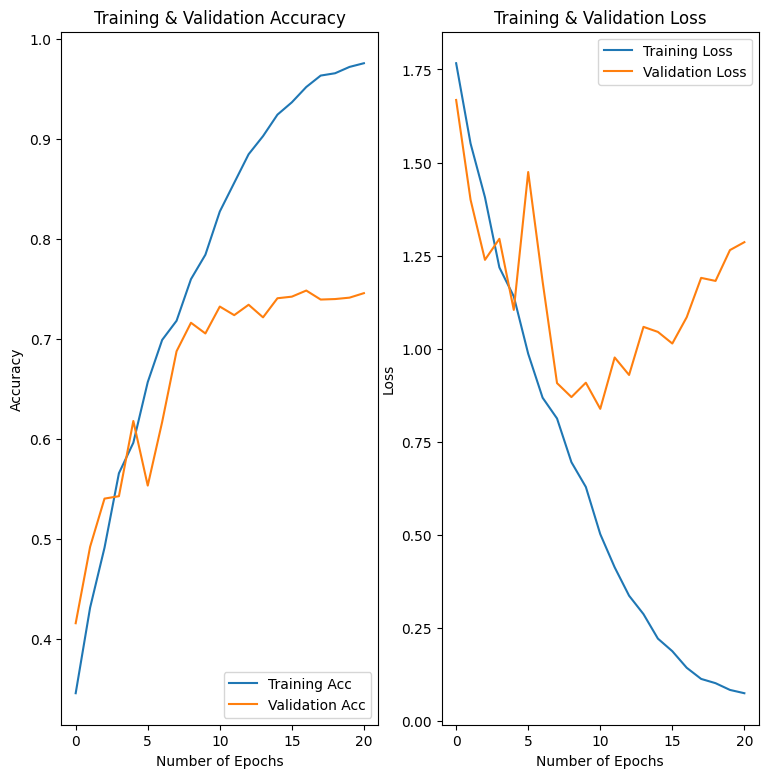

In [ ]:
plot_history(resnet_history, 21)

# Vision Transformer

In [ ]:
#Create patches
def generate_patches(images, image_patch_size):
    size_of_batch, image_height, image_width = tf.shape(images)[0], images.shape[1], images.shape[2] #Extract input dimensions
    images = tf.image.extract_patches( #TensorFlow function to extract patches from image
        images=images,
        sizes=[1, image_patch_size, image_patch_size, 1], #Patch size (patch_size x patch_size)
        strides=[1, image_patch_size, image_patch_size, 1], #Non-overlapping patches
        rates=[1, 1, 1, 1],
        padding='VALID' #Ensures no padding is applied
    )

    patch_dim = tf.shape(images)[-1] #Flattened size of each patch
    num_of_patches = (image_width//image_patch_size)*(image_height//image_patch_size) #Number of patches in each image
    return tf.reshape(images, [size_of_batch, num_of_patches, patch_dim])


#Positional encoding
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, num_of_patches,d_model): #d_model: Embedding dimension of each patch
        super(PositionalEncoding,self).__init__()
        self.positional_encoding = self.generate_pos_encoding(num_of_patches, d_model)
    def compute_angles(self, position, i, d_model):
        return position/np.power(10000,(2*(i//2))/np.float32(d_model))
    def generate_pos_encoding(self, position,d_model):
        angle = self.compute_angles(
            np.arange(position)[:,np.newaxis],
            np.arange(d_model)[np.newaxis,:],
            d_model
        )
        angle[:,0::2] = np.sin(angle[:,0::2])
        angle[:,1::2] = np.cos(angle[:,1::2])
        positional_encoding = angle[np.newaxis,...]
        return tf.cast(positional_encoding, dtype=tf.float32)

    def call(self,x):
        return x+self.positional_encoding[:,:tf.shape(x)[1],:]

#Transformer encoder block
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_of_heads, mlp_dim):
        super(TransformerEncoder, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_of_heads, key_dim=embedding_dim) #Multi-head attention(captures relationships between image patches)
        self.mlp = tf.keras.Sequential([  #Feed-forward neural network
            tf.keras.layers.Dense(mlp_dim,activation=tf.nn.gelu),
            tf.keras.layers.Dense(embedding_dim),
        ])
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6) #Layer normalization
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6) #Layer normalization
        self.dropout = tf.keras.layers.Dropout(0.1) #To prevent overfitting

    def call(self, inputs, training):
        attention_output = self.attention(inputs, inputs) #Self attention
        output1 = self.layer_norm1(inputs+attention_output) #Residual connection + normalization
        feedforward_net_output = self.mlp(output1) #Feed_forward neural network
        output2 = self.layer_norm2(output1+feedforward_net_output) #Residual connection + normalization
        return self.dropout(output2, training=training)

#Vision transformer
class VisionTransformer(tf.keras.Model):
    def __init__(self, image_size, patch_size, d_model, num_of_heads, mlp_dim, num_of_layers, num_of_classes):
        super(VisionTransformer, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_of_patches = (image_size//patch_size)**2
        self.image_patches = generate_patches #Patch generation
        self.positional_embedding = PositionalEncoding(self.num_of_patches, d_model)
        self.encoder_layers = [TransformerEncoder(d_model, num_of_heads, mlp_dim) for _ in range(num_of_layers)] #Creates list of transformer encoder blocks
        self.flatten_output = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(num_of_classes)

    def call(self,x,training=False):
        x = self.image_patches(x, self.patch_size) #Splits the input image into patches
        x = self.positional_embedding(x) #Add positional information to each patch embedding
        for encoder_layer in self.encoder_layers: #Passes the input through the stack of transformer encoder layers
            x = encoder_layer(x, training=training)
        x = self.flatten_output(x)
        return self.dense(x)

In [ ]:
#ViT model parameters
image_patch_size = 4
d_model = 48
num_of_heads = 8
mlp_dim = 128
num_of_layers = 4

#Compile the model
vit_model = VisionTransformer(image_size, image_patch_size, d_model, num_of_heads, mlp_dim, num_of_layers, num_of_classes)
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
#Model training
vit_history = vit_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=num_of_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, learning_rate_scheduler]
)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 0.2847 - loss: 2.0662 - val_accuracy: 0.5051 - val_loss: 1.3985 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5099 - loss: 1.3613 - val_accuracy: 0.5569 - val_loss: 1.2231 - learning_rate: 9.5000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5705 - loss: 1.2079 - val_accuracy: 0.5806 - val_loss: 1.2174 - learning_rate: 9.0250e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5994 - loss: 1.1156 - val_accuracy: 0.6137 - val_loss: 1.0985 - learning_rate: 8.5737e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6320 - loss: 1.0363 - val_accuracy: 0.6238 - val_loss: 1.0605 - learning_rate: 8.1451e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6500 - loss: 0.9861 - val_accuracy: 0.6477 - val_loss: 1.0065 - learning_rate: 7.7378e-04
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13

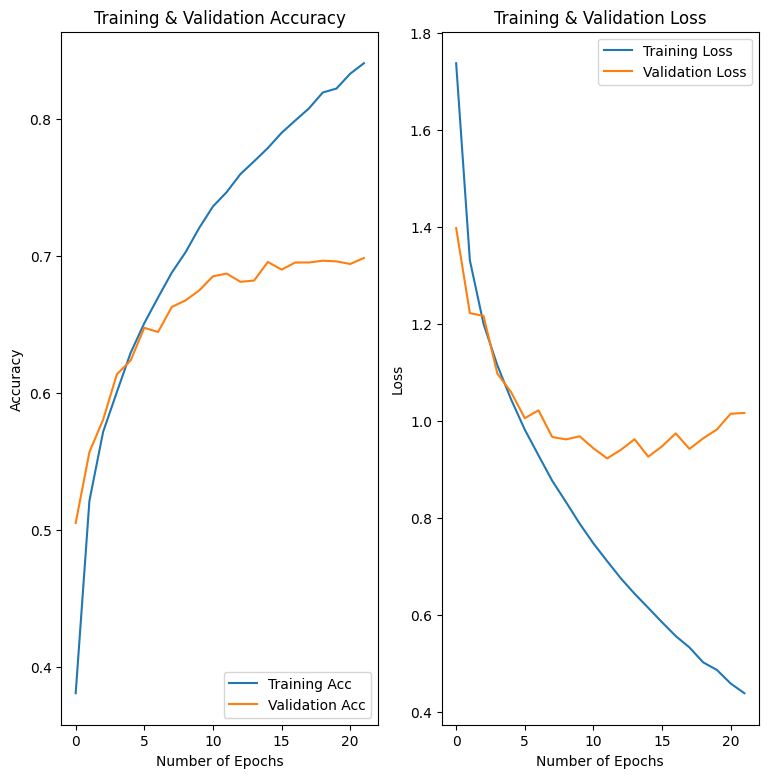

In [ ]:
plot_history(vit_history, 22)

# Model Evaluation

In [ ]:
def evaluate_model(model, model_name, x_test, y_test):
    #Prediction
    y_predicted = model.predict(x_test) #Generates predictions (2D array shape of (10000,10))
    y_predicted_classes = np.argmax(y_predicted,axis=1) #Get the index of the highest probability for each row

    # confusion matrix
    c_matrix = confusion_matrix(y_test,y_predicted_classes)
    plt.figure(figsize=(9,9))
    sns.heatmap(c_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Objects')
    plt.ylabel('True Objects')
    plt.title('Confusion Matrix')
    plt.show()

    #Calculate metrics
    accuracy = accuracy_score(y_test,y_predicted_classes)
    precision = precision_score(y_test,y_predicted_classes,average='weighted')
    recall = recall_score(y_test,y_predicted_classes,average='weighted')
    f1score = f1_score(y_test,y_predicted_classes,average='weighted')

    print(f"{model_name} Accuracy : {accuracy}")
    print(f"{model_name} Precision: {precision}")
    print(f"{model_name} Recall   : {recall}")
    print(f"{model_name} F1 Score : {f1score}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


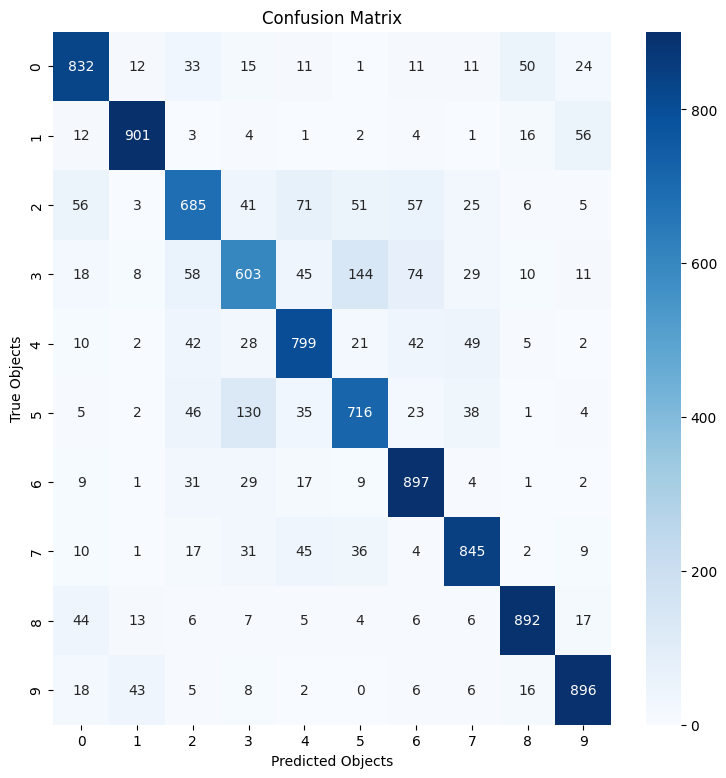

CNN Model Accuracy : 0.8066
CNN Model Precision: 0.8047219122075273
CNN Model Recall   : 0.8066
CNN Model F1 Score : 0.8050248002367125


In [ ]:
#CNN
evaluate_model(cnn_model, "CNN Model", x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step


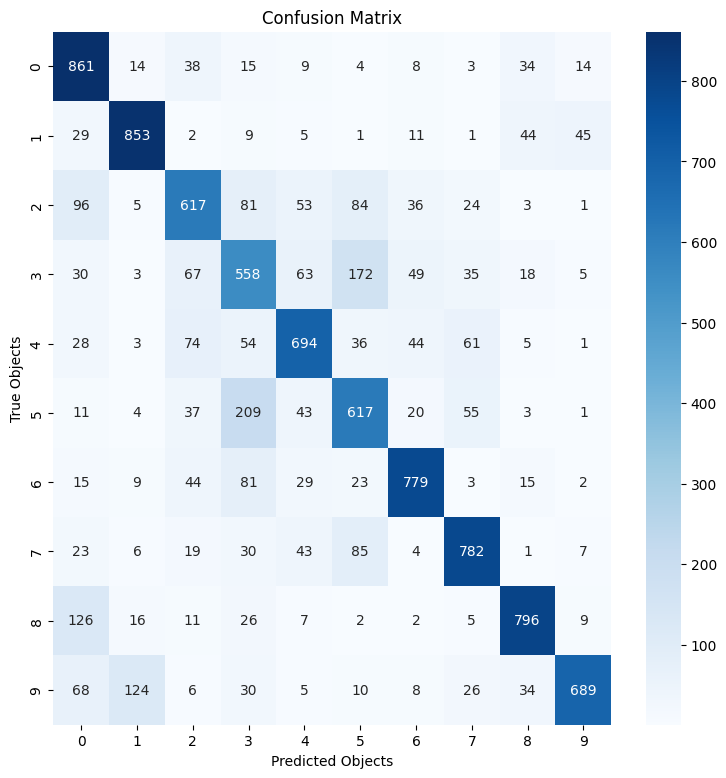

ResNet Model Accuracy : 0.7246
ResNet Model Precision: 0.7324852702611045
ResNet Model Recall   : 0.7246
ResNet Model F1 Score : 0.7256550640802268


In [ ]:
#ResNet
evaluate_model(resnet_model, "ResNet Model", x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


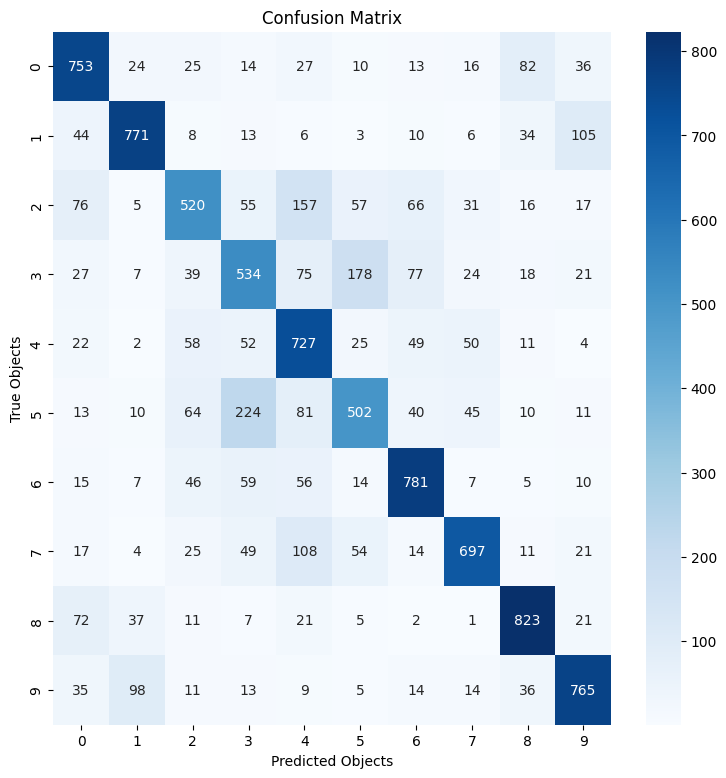

ViT Model Accuracy : 0.6873
ViT Model Precision: 0.6888675761469016
ViT Model Recall   : 0.6873
ViT Model F1 Score : 0.6856857206995685


In [ ]:
#ViT
evaluate_model(vit_model, "ViT Model", x_val, y_val)